<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/CatBoast(_3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# CatBoost Agricultural Production Classification - Step by Step Guide
# Run each step one by one for better understanding

# =============================================================================
# STEP 1: INSTALL AND IMPORT REQUIRED LIBRARIES
# =============================================================================
# First, install required packages (run in terminal/command prompt):
# pip install catboost pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


In [3]:

# =============================================================================
# STEP 2: LOAD THE DATA
# =============================================================================
print("\n" + "="*50)
print("STEP 2: LOADING DATA")
print("="*50)

# Load the three CSV files
try:
    train_df = pd.read_csv("/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv")
    val_df = pd.read_csv("/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv")

    print(f"✓ Training data loaded: {train_df.shape}")
    print(f"✓ Validation data loaded: {val_df.shape}")
    print(f"✓ Test data loaded: {test_df.shape}")

    # Display basic info about the data
    print(f"\nFirst few columns: {list(train_df.columns[:5])}")
    print(f"Target column: Production (M.Ton)")
    print(f"Production range in training: {train_df['Production (M.Ton)'].min():.2f} - {train_df['Production (M.Ton)'].max():.2f}")

except FileNotFoundError as e:
    print("❌ Error: CSV files not found!")
    print("Please make sure you have train.csv, validation.csv, and test.csv in your working directory")
    print("Stopping execution...")
    exit()


STEP 2: LOADING DATA
✓ Training data loaded: (3584, 84)
✓ Validation data loaded: (768, 84)
✓ Test data loaded: (768, 84)

First few columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C) ', 'Year', 'soil_temperature_0_to_7cm(C)']
Target column: Production (M.Ton)
Production range in training: 0.00 - 544979.54



STEP 3: DATA EXPLORATION
Missing values in training data:
Total missing values: 0

Production statistics (Training data):
count      3584.000000
mean       7087.490993
std       28934.768859
min           0.000000
25%         732.500000
50%        2050.000000
75%        5291.250000
max      544979.540000
Name: Production (M.Ton), dtype: float64


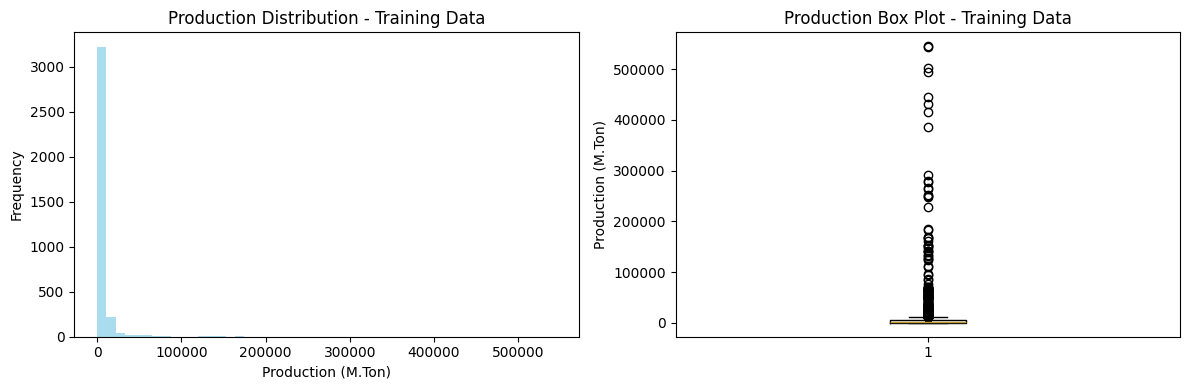

In [4]:


# =============================================================================
# STEP 3: EXPLORE THE DATA
# =============================================================================
print("\n" + "="*50)
print("STEP 3: DATA EXPLORATION")
print("="*50)

# Check for missing values
print("Missing values in training data:")
missing_values = train_df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")

# Basic statistics of production
print(f"\nProduction statistics (Training data):")
print(train_df['Production (M.Ton)'].describe())

# Plot production distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_df['Production (M.Ton)'], bins=50, alpha=0.7, color='skyblue')
plt.title('Production Distribution - Training Data')
plt.xlabel('Production (M.Ton)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(train_df['Production (M.Ton)'])
plt.title('Production Box Plot - Training Data')
plt.ylabel('Production (M.Ton)')

plt.tight_layout()
plt.show()


In [5]:

# =============================================================================
# STEP 4: CREATE QUANTILE-BASED LABELS
# =============================================================================
print("\n" + "="*50)
print("STEP 4: CREATING PRODUCTION LABELS")
print("="*50)

# Calculate quantiles from training data only
production_values = train_df['Production (M.Ton)']
low_threshold = production_values.quantile(0.33)
high_threshold = production_values.quantile(0.67)

print(f"Quantile thresholds:")
print(f"Low threshold (33rd percentile): {low_threshold:.2f}")
print(f"High threshold (67th percentile): {high_threshold:.2f}")

# Function to create labels
def create_production_labels(df, low_thresh, high_thresh):
    """Create production category labels"""
    return pd.cut(
        df['Production (M.Ton)'],
        bins=[-np.inf, low_thresh, high_thresh, np.inf],
        labels=['low', 'medium', 'high']
    )

# Apply labeling to all datasets
train_df['production_category'] = create_production_labels(train_df, low_threshold, high_threshold)
val_df['production_category'] = create_production_labels(val_df, low_threshold, high_threshold)
test_df['production_category'] = create_production_labels(test_df, low_threshold, high_threshold)

# Print distribution for each dataset
for df, name in [(train_df, 'Training'), (val_df, 'Validation'), (test_df, 'Test')]:
    print(f"\n{name} set production distribution:")
    print(df['production_category'].value_counts())
    print(f"Percentages: {(df['production_category'].value_counts(normalize=True) * 100).round(2)}")



STEP 4: CREATING PRODUCTION LABELS
Quantile thresholds:
Low threshold (33rd percentile): 1018.00
High threshold (67th percentile): 3979.00

Training set production distribution:
production_category
medium    1218
low       1184
high      1182
Name: count, dtype: int64
Percentages: production_category
medium    33.98
low       33.04
high      32.98
Name: proportion, dtype: float64

Validation set production distribution:
production_category
medium    264
high      257
low       247
Name: count, dtype: int64
Percentages: production_category
medium    34.38
high      33.46
low       32.16
Name: proportion, dtype: float64

Test set production distribution:
production_category
medium    268
low       252
high      248
Name: count, dtype: int64
Percentages: production_category
medium    34.90
low       32.81
high      32.29
Name: proportion, dtype: float64


In [6]:

# =============================================================================
# STEP 5: PREPARE FEATURES AND LABELS
# =============================================================================
print("\n" + "="*50)
print("STEP 5: PREPARING FEATURES AND LABELS")
print("="*50)

# Identify feature columns (exclude target and created category)
feature_columns = [col for col in train_df.columns
                  if col not in ['Production (M.Ton)', 'production_category']]

print(f"Total number of features: {len(feature_columns)}")
print(f"Sample features: {feature_columns[:5]}")

# Prepare features
X_train = train_df[feature_columns]
X_val = val_df[feature_columns]
X_test = test_df[feature_columns]

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['production_category'])
y_val = label_encoder.transform(val_df['production_category'])
y_test = label_encoder.transform(test_df['production_category'])

print(f"Label encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")



STEP 5: PREPARING FEATURES AND LABELS
Total number of features: 83
Sample features: ['Area (Acres)', 'Temperature at 2 Meters Range (C) ', 'Year', 'soil_temperature_0_to_7cm(C)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)']
Label encoding: {'high': 0, 'low': 1, 'medium': 2}
Training labels shape: (3584,)
Validation labels shape: (768,)
Test labels shape: (768,)


In [7]:

# =============================================================================
# STEP 6: INITIALIZE AND TRAIN CATBOOST MODEL
# =============================================================================
print("\n" + "="*50)
print("STEP 6: TRAINING CATBOOST MODEL")
print("="*50)

# Initialize CatBoost classifier
model = CatBoostClassifier(
    iterations=1000,           # Number of epochs
    learning_rate=0.1,         # Learning rate
    depth=6,                   # Tree depth
    eval_metric='MultiClass',  # Evaluation metric
    random_seed=42,            # For reproducibility
    verbose=100,               # Print progress every 100 iterations
    early_stopping_rounds=50,  # Stop if no improvement for 50 rounds
    use_best_model=True        # Use the best model from training
)

print("Starting model training...")
print("This may take a few minutes depending on your data size...")

# Train model with validation data for early stopping
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=False,
    verbose_eval=100
)

print(f"\n✓ Model training completed!")
print(f"Best iteration: {model.get_best_iteration()}")
print(f"Best score: {model.get_best_score()}")



STEP 6: TRAINING CATBOOST MODEL
Starting model training...
This may take a few minutes depending on your data size...
0:	learn: 1.0065978	test: 1.0120775	best: 1.0120775 (0)	total: 6.06ms	remaining: 6.05s
100:	learn: 0.2653443	test: 0.3144715	best: 0.3144715 (100)	total: 508ms	remaining: 4.52s
200:	learn: 0.2028784	test: 0.2608130	best: 0.2608130 (200)	total: 964ms	remaining: 3.83s
300:	learn: 0.1670457	test: 0.2377992	best: 0.2376606 (299)	total: 1.41s	remaining: 3.28s
400:	learn: 0.1417534	test: 0.2248916	best: 0.2248904 (399)	total: 1.88s	remaining: 2.8s
500:	learn: 0.1236244	test: 0.2153150	best: 0.2152611 (499)	total: 2.31s	remaining: 2.31s
600:	learn: 0.1090075	test: 0.2098756	best: 0.2098756 (600)	total: 2.77s	remaining: 1.84s
700:	learn: 0.0972326	test: 0.2053330	best: 0.2052927 (698)	total: 3.21s	remaining: 1.37s
800:	learn: 0.0867971	test: 0.2024770	best: 0.2021483 (797)	total: 3.67s	remaining: 911ms
900:	learn: 0.0777943	test: 0.1986194	best: 0.1984929 (896)	total: 4.99s	re


STEP 7: PLOTTING TRAINING HISTORY


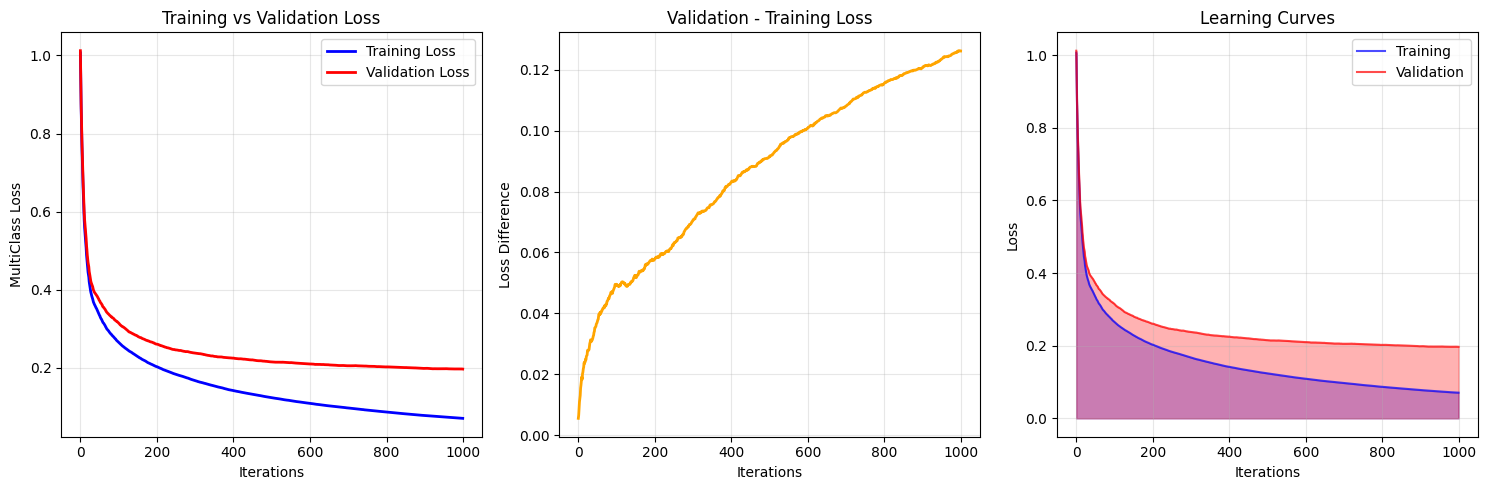

In [8]:

# =============================================================================
# STEP 7: PLOT TRAINING HISTORY
# =============================================================================
print("\n" + "="*50)
print("STEP 7: PLOTTING TRAINING HISTORY")
print("="*50)

# Get training history
evals_result = model.get_evals_result()

if 'validation' in evals_result:
    train_scores = evals_result['learn']['MultiClass']
    val_scores = evals_result['validation']['MultiClass']

    plt.figure(figsize=(15, 5))

    # Plot 1: Training vs Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_scores, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_scores, label='Validation Loss', color='red', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('MultiClass Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Loss difference
    plt.subplot(1, 3, 2)
    loss_diff = np.array(val_scores) - np.array(train_scores)
    plt.plot(loss_diff, color='orange', linewidth=2)
    plt.title('Validation - Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss Difference')
    plt.grid(True, alpha=0.3)

    # Plot 3: Learning curve
    plt.subplot(1, 3, 3)
    plt.plot(range(len(train_scores)), train_scores, 'b-', alpha=0.7, label='Training')
    plt.plot(range(len(val_scores)), val_scores, 'r-', alpha=0.7, label='Validation')
    plt.fill_between(range(len(train_scores)), train_scores, alpha=0.3, color='blue')
    plt.fill_between(range(len(val_scores)), val_scores, alpha=0.3, color='red')
    plt.title('Learning Curves')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No validation scores available for plotting.")


In [9]:

# =============================================================================
# STEP 8: EVALUATE MODEL ON VALIDATION SET
# =============================================================================
print("\n" + "="*50)
print("STEP 8: VALIDATION SET EVALUATION")
print("="*50)

# Make predictions on validation set
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)

# Calculate all metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision_macro = precision_score(y_val, y_val_pred, average='macro')
val_recall_macro = recall_score(y_val, y_val_pred, average='macro')
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

# Print validation results
print("VALIDATION SET METRICS:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision (Macro): {val_precision_macro:.4f}")
print(f"Recall (Macro): {val_recall_macro:.4f}")
print(f"F1-Score (Macro): {val_f1_macro:.4f}")
print(f"F1-Score (Weighted): {val_f1_weighted:.4f}")

# Per-class metrics
val_precision_per_class = precision_score(y_val, y_val_pred, average=None)
val_recall_per_class = recall_score(y_val, y_val_pred, average=None)
val_f1_per_class = f1_score(y_val, y_val_pred, average=None)

print(f"\nPER-CLASS METRICS (Validation):")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: Precision={val_precision_per_class[i]:.4f}, "
          f"Recall={val_recall_per_class[i]:.4f}, F1={val_f1_per_class[i]:.4f}")

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT (Validation):")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))



STEP 8: VALIDATION SET EVALUATION
VALIDATION SET METRICS:
Accuracy: 0.9193
Precision (Macro): 0.9204
Recall (Macro): 0.9199
F1-Score (Macro): 0.9201
F1-Score (Weighted): 0.9194

PER-CLASS METRICS (Validation):
high: Precision=0.9228, Recall=0.9300, F1=0.9264
low: Precision=0.9588, Recall=0.9433, F1=0.9510
medium: Precision=0.8797, Recall=0.8864, F1=0.8830

DETAILED CLASSIFICATION REPORT (Validation):
              precision    recall  f1-score   support

        high       0.92      0.93      0.93       257
         low       0.96      0.94      0.95       247
      medium       0.88      0.89      0.88       264

    accuracy                           0.92       768
   macro avg       0.92      0.92      0.92       768
weighted avg       0.92      0.92      0.92       768



In [10]:

# =============================================================================
# STEP 9: EVALUATE MODEL ON TEST SET
# =============================================================================
print("\n" + "="*50)
print("STEP 9: TEST SET EVALUATION")
print("="*50)

# Make predictions on test set
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)

# Calculate all metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Print test results
print("TEST SET METRICS:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (Macro): {test_precision_macro:.4f}")
print(f"Recall (Macro): {test_recall_macro:.4f}")
print(f"F1-Score (Macro): {test_f1_macro:.4f}")
print(f"F1-Score (Weighted): {test_f1_weighted:.4f}")

# Per-class metrics
test_precision_per_class = precision_score(y_test, y_test_pred, average=None)
test_recall_per_class = recall_score(y_test, y_test_pred, average=None)
test_f1_per_class = f1_score(y_test, y_test_pred, average=None)

print(f"\nPER-CLASS METRICS (Test):")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: Precision={test_precision_per_class[i]:.4f}, "
          f"Recall={test_recall_per_class[i]:.4f}, F1={test_f1_per_class[i]:.4f}")

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT (Test):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))



STEP 9: TEST SET EVALUATION
TEST SET METRICS:
Accuracy: 0.9336
Precision (Macro): 0.9348
Recall (Macro): 0.9340
F1-Score (Macro): 0.9343
F1-Score (Weighted): 0.9337

PER-CLASS METRICS (Test):
high: Precision=0.9465, Recall=0.9274, F1=0.9369
low: Precision=0.9603, Recall=0.9603, F1=0.9603
medium: Precision=0.8974, Recall=0.9142, F1=0.9057

DETAILED CLASSIFICATION REPORT (Test):
              precision    recall  f1-score   support

        high       0.95      0.93      0.94       248
         low       0.96      0.96      0.96       252
      medium       0.90      0.91      0.91       268

    accuracy                           0.93       768
   macro avg       0.93      0.93      0.93       768
weighted avg       0.93      0.93      0.93       768




STEP 10: PLOTTING CONFUSION MATRICES


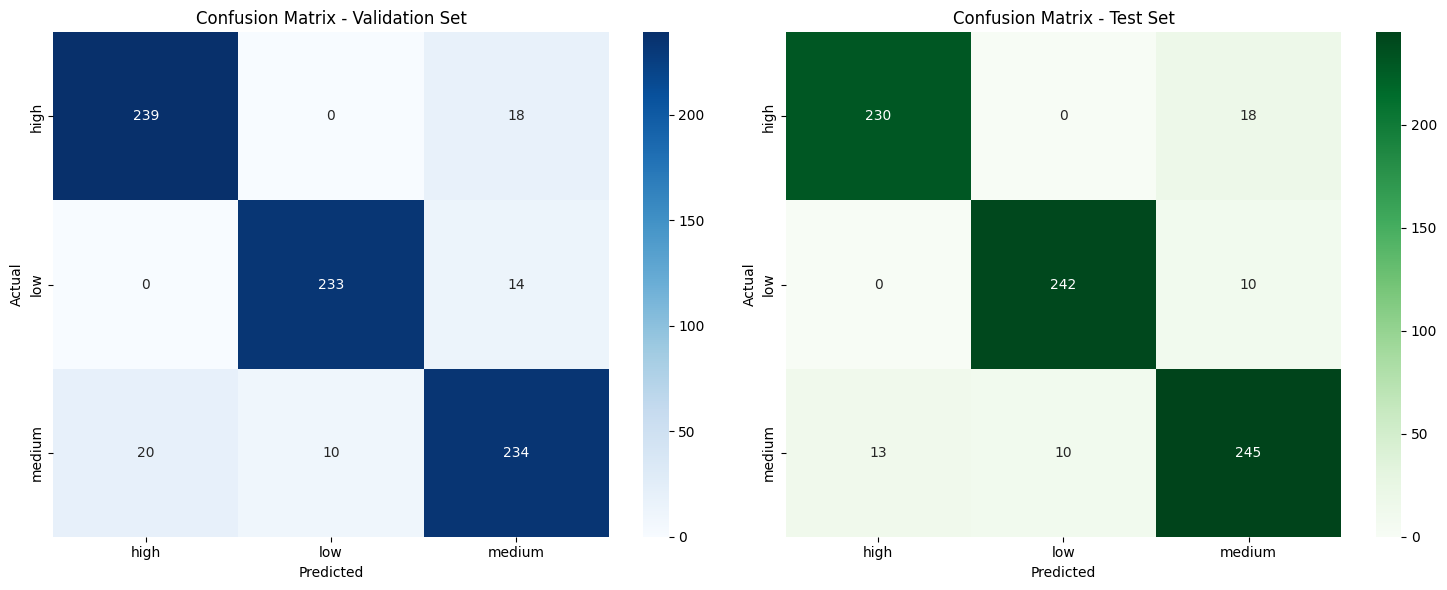

In [11]:

# =============================================================================
# STEP 10: PLOT CONFUSION MATRICES
# =============================================================================
print("\n" + "="*50)
print("STEP 10: PLOTTING CONFUSION MATRICES")
print("="*50)

# Create confusion matrices
val_cm = confusion_matrix(y_val, y_val_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(15, 6))

# Validation confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Test confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()



STEP 11: PLOTTING ACCURACY COMPARISON


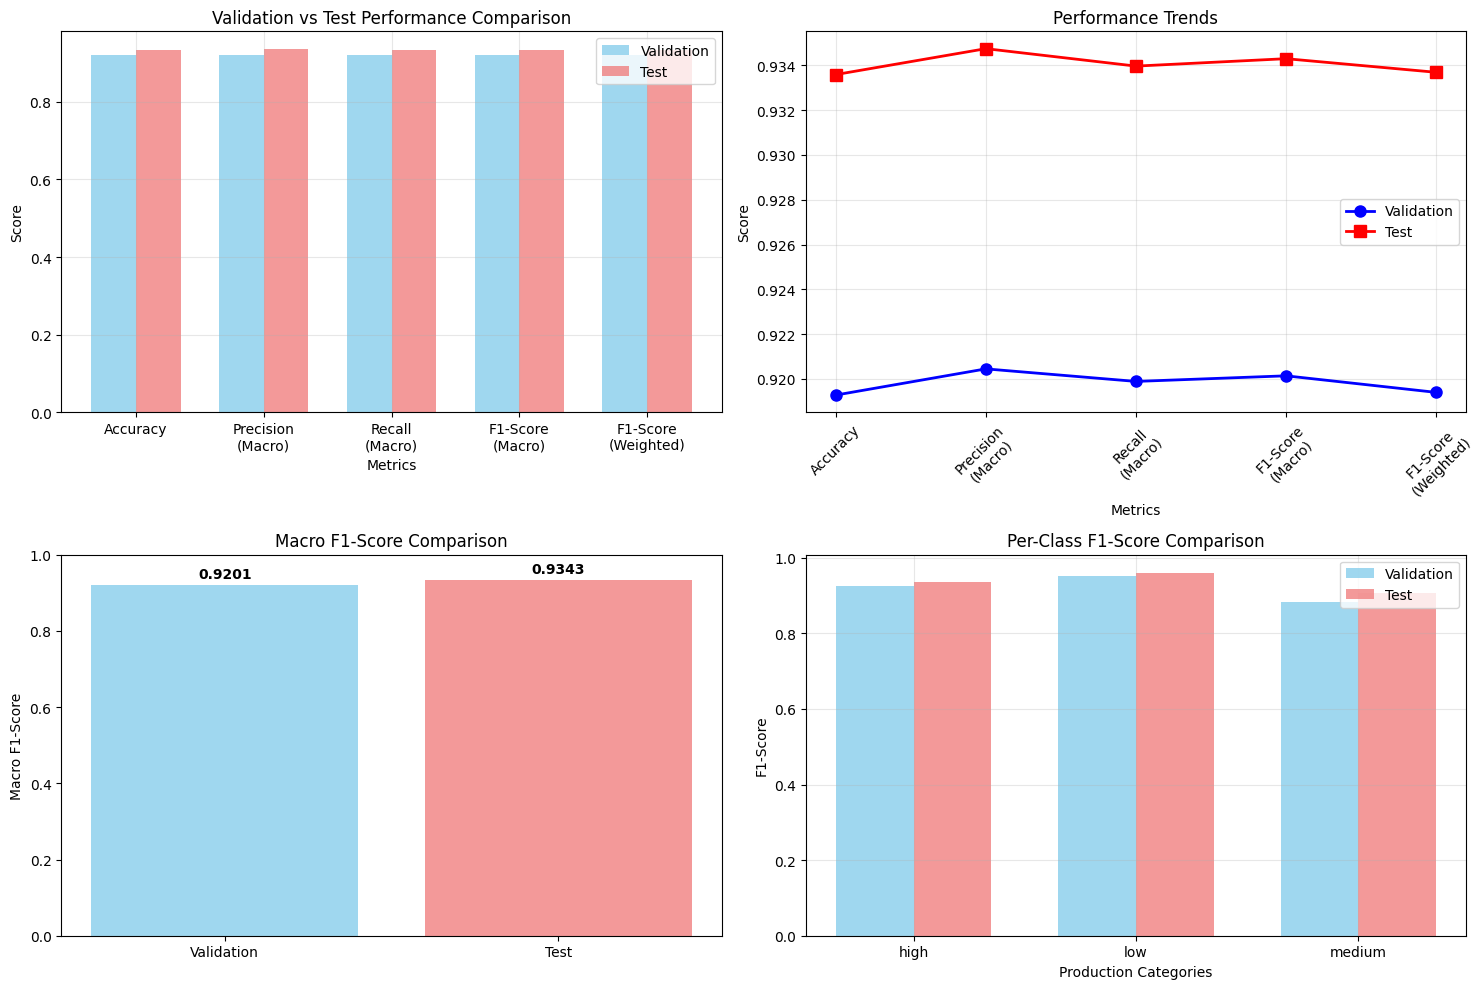

In [12]:

# =============================================================================
# STEP 11: PLOT ACCURACY COMPARISON
# =============================================================================
print("\n" + "="*50)
print("STEP 11: PLOTTING ACCURACY COMPARISON")
print("="*50)

# Create comparison data
metrics_names = ['Accuracy', 'Precision\n(Macro)', 'Recall\n(Macro)', 'F1-Score\n(Macro)', 'F1-Score\n(Weighted)']
validation_scores = [val_accuracy, val_precision_macro, val_recall_macro, val_f1_macro, val_f1_weighted]
test_scores = [test_accuracy, test_precision_macro, test_recall_macro, test_f1_macro, test_f1_weighted]

# Create comparison plots
plt.figure(figsize=(15, 10))

# Bar plot comparison
plt.subplot(2, 2, 1)
x = np.arange(len(metrics_names))
width = 0.35
plt.bar(x - width/2, validation_scores, width, label='Validation', color='skyblue', alpha=0.8)
plt.bar(x + width/2, test_scores, width, label='Test', color='lightcoral', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Validation vs Test Performance Comparison')
plt.xticks(x, metrics_names)
plt.legend()
plt.grid(True, alpha=0.3)

# Line plot comparison
plt.subplot(2, 2, 2)
plt.plot(metrics_names, validation_scores, 'o-', linewidth=2, markersize=8, label='Validation', color='blue')
plt.plot(metrics_names, test_scores, 's-', linewidth=2, markersize=8, label='Test', color='red')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Trends')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Macro F1 Score focus
plt.subplot(2, 2, 3)
categories = ['Validation', 'Test']
macro_f1_scores = [val_f1_macro, test_f1_macro]
colors = ['skyblue', 'lightcoral']
bars = plt.bar(categories, macro_f1_scores, color=colors, alpha=0.8)
plt.ylabel('Macro F1-Score')
plt.title('Macro F1-Score Comparison')
plt.ylim(0, 1)
# Add value labels on bars
for bar, score in zip(bars, macro_f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Per-class F1 scores comparison
plt.subplot(2, 2, 4)
x = np.arange(len(label_encoder.classes_))
width = 0.35
plt.bar(x - width/2, val_f1_per_class, width, label='Validation', color='skyblue', alpha=0.8)
plt.bar(x + width/2, test_f1_per_class, width, label='Test', color='lightcoral', alpha=0.8)
plt.xlabel('Production Categories')
plt.ylabel('F1-Score')
plt.title('Per-Class F1-Score Comparison')
plt.xticks(x, label_encoder.classes_)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



STEP 12: FEATURE IMPORTANCE ANALYSIS
Top 20 Most Important Features:
                                         feature  importance
                                    Area (Acres)   43.947747
                                    Crop_Cabbage    4.889823
                                            Year    4.159781
                                     Crop_Garlic    3.812184
              Temperature at 2 Meters Range (C)     3.530561
                                      Crop_Beans    3.420066
                                    Crop_Laushak    3.285517
                    soil_temperature_0_to_7cm(C)    3.173220
                                     Crop_Radish    3.134671
                                     Crop_Tomato    3.020559
                                Crop_Cauliflower    2.790014
                 soil_moisture_0_to_7cm(mÂ³/mÂ³)    2.490663
                                   total_rain_mm    2.241865
                         relative_humidity_2m(%)    2.207823
               

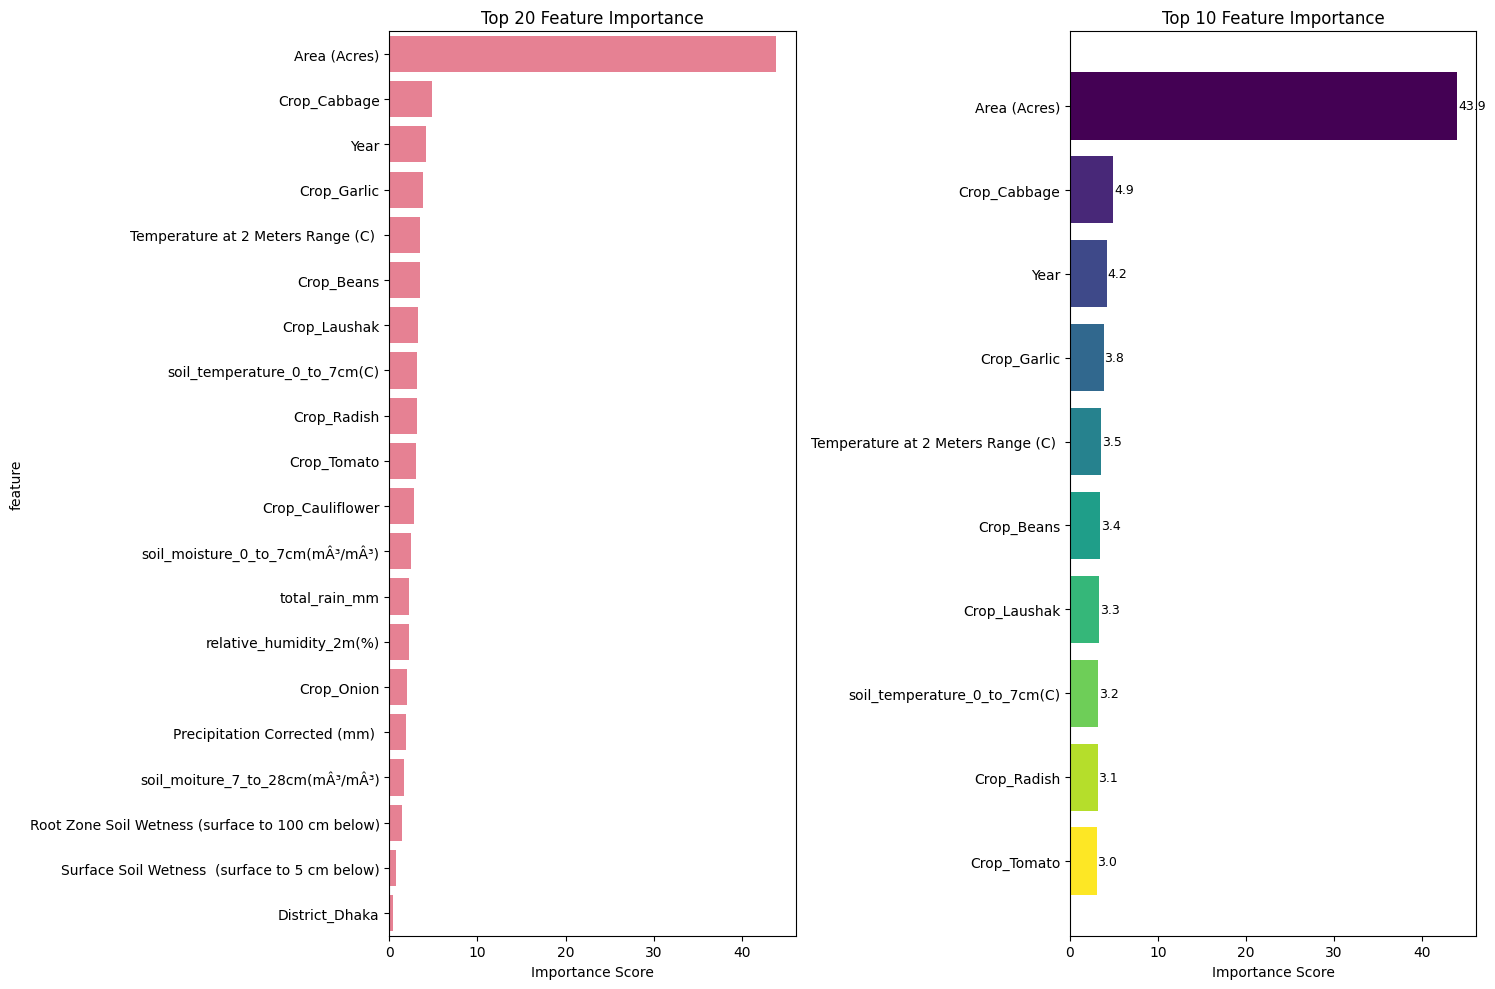

In [13]:



# =============================================================================
# STEP 12: FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n" + "="*50)
print("STEP 12: FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance
feature_importance = model.get_feature_importance()
feature_names = feature_columns

# Create DataFrame for easier handling
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(15, 10))

# Top 20 features
plt.subplot(1, 2, 1)
top_20 = importance_df.head(20)
sns.barplot(data=top_20, x='importance', y='feature')
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance Score')

# Top 10 features with better visibility
plt.subplot(1, 2, 2)
top_10 = importance_df.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10)))
bars = plt.barh(range(len(top_10)), top_10['importance'], color=colors)
plt.yticks(range(len(top_10)), top_10['feature'])
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()

# Add value labels
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'{top_10.iloc[i]["importance"]:.1f}',
             va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [14]:

# =============================================================================
# STEP 13: FINAL SUMMARY AND RESULTS
# =============================================================================
print("\n" + "="*60)
print("STEP 13: FINAL SUMMARY AND RESULTS")
print("="*60)

print("QUANTILE THRESHOLDS:")
print(f"Low production threshold: {low_threshold:.2f} M.Ton")
print(f"High production threshold: {high_threshold:.2f} M.Ton")

print(f"\nMODEL TRAINING SUMMARY:")
print(f"Total features used: {len(feature_columns)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Best iteration: {model.get_best_iteration()}")

print(f"\nVALIDATION SET PERFORMANCE:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Macro F1-Score: {val_f1_macro:.4f}")
print(f"Weighted F1-Score: {val_f1_weighted:.4f}")

print(f"\nTEST SET PERFORMANCE:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Macro F1-Score: {test_f1_macro:.4f}")
print(f"Weighted F1-Score: {test_f1_weighted:.4f}")

print(f"\nTOP 5 MOST IMPORTANT FEATURES:")
for i, row in importance_df.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.2f}")

print(f"\n{'='*60}")
print("CLASSIFICATION MODEL COMPLETED SUCCESSFULLY!")
print("="*60)



STEP 13: FINAL SUMMARY AND RESULTS
QUANTILE THRESHOLDS:
Low production threshold: 1018.00 M.Ton
High production threshold: 3979.00 M.Ton

MODEL TRAINING SUMMARY:
Total features used: 83
Training samples: 3584
Validation samples: 768
Test samples: 768
Best iteration: 999

VALIDATION SET PERFORMANCE:
Accuracy: 0.9193
Macro F1-Score: 0.9201
Weighted F1-Score: 0.9194

TEST SET PERFORMANCE:
Accuracy: 0.9336
Macro F1-Score: 0.9343
Weighted F1-Score: 0.9337

TOP 5 MOST IMPORTANT FEATURES:
Area (Acres): 43.95
Crop_Cabbage: 4.89
Year: 4.16
Crop_Garlic: 3.81
Temperature at 2 Meters Range (C) : 3.53

CLASSIFICATION MODEL COMPLETED SUCCESSFULLY!


In [15]:

# =============================================================================
# STEP 14: SAMPLE PREDICTIONS (BONUS)
# =============================================================================
print("\n" + "="*50)
print("STEP 14: SAMPLE PREDICTIONS")
print("="*50)

# Show some sample predictions
sample_size = min(10, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

print("Sample Predictions vs Actual Values:")
print("-" * 80)
print("Index  Actual   Predicted  Confidence   Correct")
print("-" * 80)

for i, idx in enumerate(sample_indices):
    # Get the actual values safely
    idx_val = int(idx)
    actual_class_idx = int(y_test[idx])
    pred_class_idx = int(y_test_pred[idx])

    # Get class names
    actual_label = label_encoder.classes_[actual_class_idx]
    pred_label = label_encoder.classes_[pred_class_idx]

    # Get confidence (convert numpy array to float)
    confidence_val = y_test_pred_proba[idx]
    max_confidence = float(np.max(confidence_val))

    # Check if correct
    is_correct = "✓" if actual_label == pred_label else "✗"

    # Print using .format() instead of f-strings to avoid numpy issues
    print("{:<6} {:<8} {:<10} {:.3f}       {}".format(
        idx_val, actual_label, pred_label, max_confidence, is_correct
    ))

print("\n" + "="*60)
print("ALL STEPS COMPLETED! Your CatBoost model is ready for use.")
print("="*60)


STEP 14: SAMPLE PREDICTIONS
Sample Predictions vs Actual Values:
--------------------------------------------------------------------------------
Index  Actual   Predicted  Confidence   Correct
--------------------------------------------------------------------------------
668    medium   medium     0.968       ✓
392    medium   medium     0.941       ✓
360    high     high       0.957       ✓
596    low      low        1.000       ✓
524    medium   medium     0.725       ✓
161    low      low        0.895       ✓
361    high     high       0.997       ✓
233    high     high       0.983       ✓
321    high     high       0.992       ✓
666    high     high       0.730       ✓

ALL STEPS COMPLETED! Your CatBoost model is ready for use.
